In [1]:
from google.colab import drive
drive .mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
rootpath='/content/gdrive/My Drive/bengalchar/bengalichar'

In [0]:
lis=[]
import os
for dirname, _, filenames in os.walk(rootpath):
    for filename in filenames:
        lis.append(os.path.join(dirname, filename))

In [4]:
lis

['/content/gdrive/My Drive/bengalchar/bengalichar/class_map.csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/train_multi_diacritics (1).csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/Untitled (1).ipynb',
 '/content/gdrive/My Drive/bengalchar/bengalichar/sample_submission (1).csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/class_map_corrected.csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/test.csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/sample_submission.csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/Untitled.ipynb',
 '/content/gdrive/My Drive/bengalchar/bengalichar/train_multi_diacritics.csv',
 '/content/gdrive/My Drive/bengalchar/bengalichar/train_image_data_1.parquet',
 '/content/gdrive/My Drive/bengalchar/bengalichar/test_image_data_0.parquet',
 '/content/gdrive/My Drive/bengalchar/bengalichar/train_image_data_3.parquet',
 '/content/gdrive/My Drive/bengalchar/bengalichar/test_image_data_3.parquet',
 '/content/gdrive/My Drive/beng

In [5]:
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
import albumentations as A

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [0]:
train_df_=pd.read_csv('/content/gdrive/My Drive/bengalchar/bengalichar/train.csv')
test_df_=pd.read_csv('/content/gdrive/My Drive/bengalchar/bengalichar/test.csv')
class_map_df_=pd.read_csv('/content/gdrive/My Drive/bengalchar/bengalichar/class_map.csv')
sample_sub_df_=pd.read_csv('/content/gdrive/My Drive/bengalchar/bengalichar/sample_submission.csv')
multi_diac_df_=pd.read_csv('/content/gdrive/My Drive/bengalchar/bengalichar/train_multi_diacritics.csv')

In [7]:
train_df.head(10)

NameError: ignored

In [0]:
test_df.head(10)

In [0]:
class_map_df.head(10)

In [0]:
sample_sub_df.head()

In [0]:
multi_diac_df.head()

In [0]:
print(f'Size of training data: {train_df.shape}')
print(f'Size of test data: {test_df.shape}')
print(f'Size of class map: {class_map_df.shape}')

In [0]:
HEIGHT = 200
WIDTH = 200


def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df.iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

In [0]:
df=pd.read_parquet('/content/gdrive/My Drive/bengalchar/bengalichar/train_image_data_1.parquet')

In [0]:
df

In [10]:


IMG_SIZE=64
N_CHANNELS=1

inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
#decreased batch size
batch_size = 256
epochs = 30

class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)

        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                                shuffle=shuffle):
                    target_dict = {}
                    i = 0
                    for output in ordered_outputs:
                        target_length = target_lengths[output]
                        target_dict[output] = flowy[:, i: i + target_length]
                        i += target_length

                    yield flowx, target_dict


In [0]:


HEIGHT = 137
WIDTH = 236
SIZE = 64
CROP_SIZE = 64



def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    angle=0
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            #Centering
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
            #Scaling
            matrix = cv2.getRotationMatrix2D(image_center, 0, 1.0)
            image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
            #Removing Blur
            #aug = A.GaussianBlur(p=1.0)
            #image = aug(image=image)['image']
            #Noise Removing
            #augNoise=A.MultiplicativeNoise(p=1.0)
            #image = augNoise(image=image)['image']
            #Removing Distortion
            #augDist=A.ElasticTransform(sigma=50, alpha=1, alpha_affine=10, p=1.0)
            #image = augDist(image=image)['image']
            #Brightness
            augBright=A.RandomBrightnessContrast(p=1.0)
            image = augBright(image=image)['image']
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            #image=affine_image(image)
            #image= crop_resize(image)
            #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
            #image=resize_image(image,(64,64))
            #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
            #gaussian_3 = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT) #unblur
            #image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
            #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
            #image = cv2.filter2D(image, -1, kernel)
            #ret,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
            matrix = cv2.getRotationMatrix2D(image_center, 0, 1.0)
            image = cv2.warpAffine(image, matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
            #Removing Blur
            #aug = A.GaussianBlur(p=1.0)
            #image = aug(image=image)['image']
            #Noise Removing
            #augNoise=A.MultiplicativeNoise(p=1.0)
            #image = augNoise(image=image)['image']
            #Removing Distortion
            #augDist=A.ElasticTransform(sigma=50, alpha=1, alpha_affine=10, p=1.0)
            #image = augDist(image=image)['image']
            #Brightness
            augBright=A.RandomBrightnessContrast(p=1.0)
            image = augBright(image=image)['image']
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            #image=affine_image(image)
            #image= crop_resize(image)
            #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
            #image=resize_image(image,(64,64))
            #image = cv2.resize(image,(size,size),interpolation=cv2.INTER_AREA)
            #gaussian_3 = cv2.GaussianBlur(image, (5,5), cv2.BORDER_DEFAULT) #unblur
            #image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
            #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
            #image = cv2.filter2D(image, -1, kernel)
            #ret,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

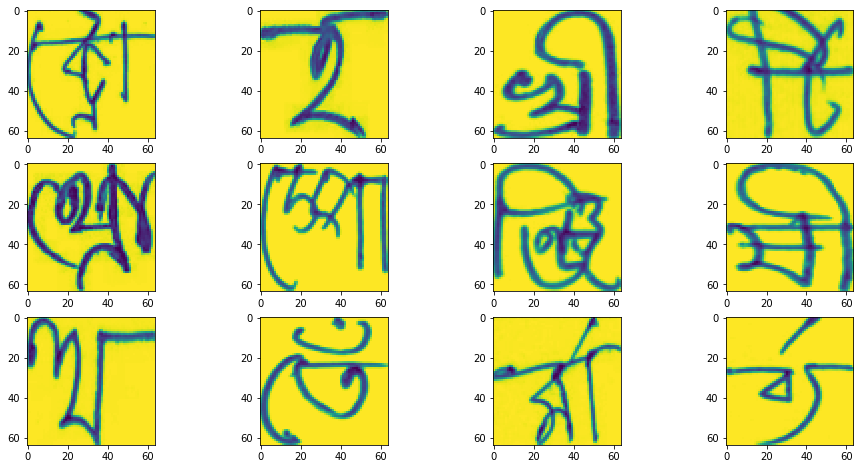

(50210, 32332)



Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
180/180 [==============================] - 99s 550ms/step - loss: 8.0343 - dense_3_loss: 4.8123 - dense_4_loss: 1.9948 - dense_5_loss: 1.2272 - dense_3_acc: 0.0280 - dense_4_acc: 0.3076 - dense_5_acc: 0.6213 - val_loss: 7.2465 - val_dense_3_loss: 4.6831 - val_dense_4_loss: 1.4589 - val_dense_5_loss: 1.1046 - val_dense_3_acc: 0.0336 - val_dense_4_acc: 0.5044 - val_dense_5_acc: 0.6241
Epoch 2/30
180/180 [==============================] - 84s 468ms/step - loss: 6.7740 - dense_3_loss: 4.4861 - dense_4_loss: 1.2832 - dense_5_loss: 1.0047 - dense_3_acc: 0.0454 - dense_4_acc: 0.5581 - dense_5_acc: 0.6543 - val_loss: 5.9973 - val_dense_3_loss: 4.2248 - val_dense_4_loss: 0.9194 - val_dense_5_loss: 0.8531 - val_dense_3_acc: 0.0717 - val_dense_4_ac

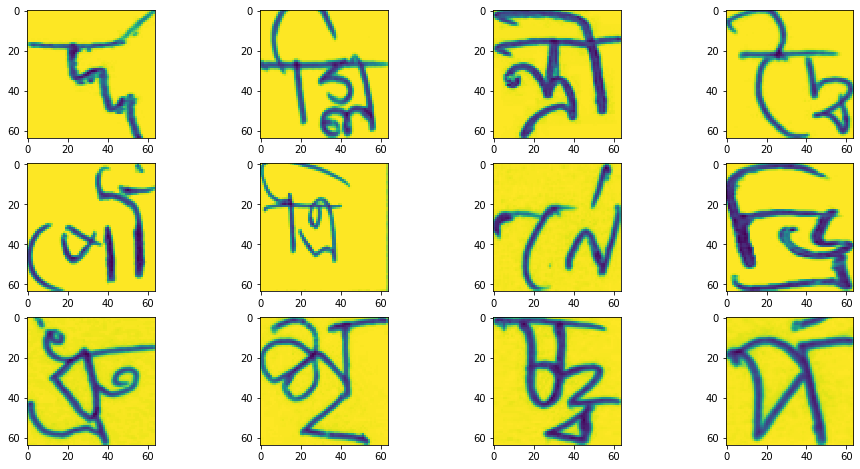

(50210, 32332)



Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 84s 465ms/step - loss: 1.2658 - dense_3_loss: 0.7355 - dense_4_loss: 0.3131 - dense_5_loss: 0.2172 - dense_3_acc: 0.7989 - dense_4_acc: 0.9052 - dense_5_acc: 0.9332 - val_loss: 0.5708 - val_dense_3_loss: 0.3601 - val_dense_4_loss: 0.1144 - val_dense_5_loss: 0.0963 - val_dense_3_acc: 0.8999 - val_dense_4_acc: 0.9719 - val_dense_5_acc: 0.9716
Epoch 2/30
180/180 [==============================] - 83s 459ms/step - loss: 1.0587 - dense_3_loss: 0.6092 - dense_4_loss: 0.2643 - dense_5_loss: 0.1852 - dense_3_acc: 0.8277 - dense_4_acc: 0.9198 - dense_5_acc: 0.9422 - val_loss: 0.5390 - val_dense_3_loss: 0.3297 - val_dense_4_loss: 0.1227 - val_dense_5_loss: 0.0866 - val_dense_3_acc: 0.9074 - val_dense_4_acc: 0.9686 - val_dense_5_acc: 0.9744
Epoch 3/30
180/180 [==============================] - 83s 46

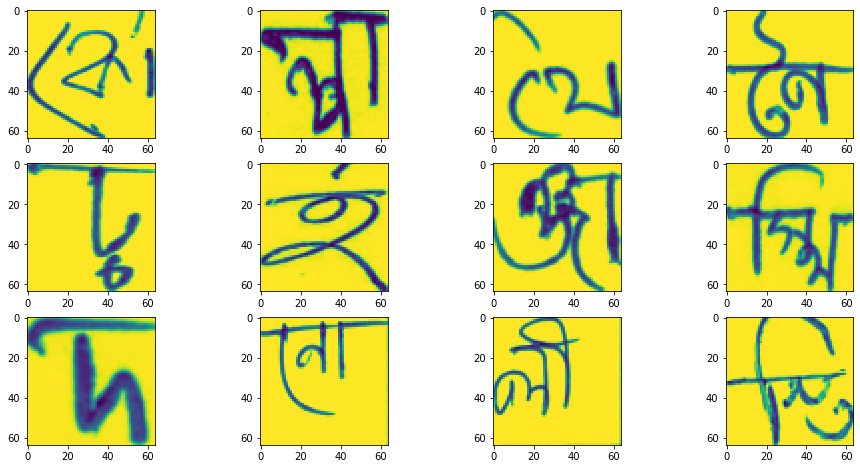

(50210, 32332)



Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 84s 465ms/step - loss: 0.9724 - dense_3_loss: 0.5632 - dense_4_loss: 0.2387 - dense_5_loss: 0.1705 - dense_3_acc: 0.8471 - dense_4_acc: 0.9286 - dense_5_acc: 0.9457 - val_loss: 0.5332 - val_dense_3_loss: 0.3189 - val_dense_4_loss: 0.1194 - val_dense_5_loss: 0.0948 - val_dense_3_acc: 0.9136 - val_dense_4_acc: 0.9637 - val_dense_5_acc: 0.9699
Epoch 2/30
180/180 [==============================] - 83s 459ms/step - loss: 0.8896 - dense_3_loss: 0.5022 - dense_4_loss: 0.2292 - dense_5_loss: 0.1582 - dense_3_acc: 0.8605 - dense_4_acc: 0.9295 - dense_5_acc: 0.9492 - val_loss: 0.5229 - val_dense_3_loss: 0.3071 - val_dense_4_loss: 0.1196 - val_dense_5_loss: 0.0963 - val_dense_3_acc: 0.9161 - val_dense_4_acc: 0.9714 - val_dense_5_acc: 0.9701
Epoch 3/30
180/180 [==============================] - 83s 45

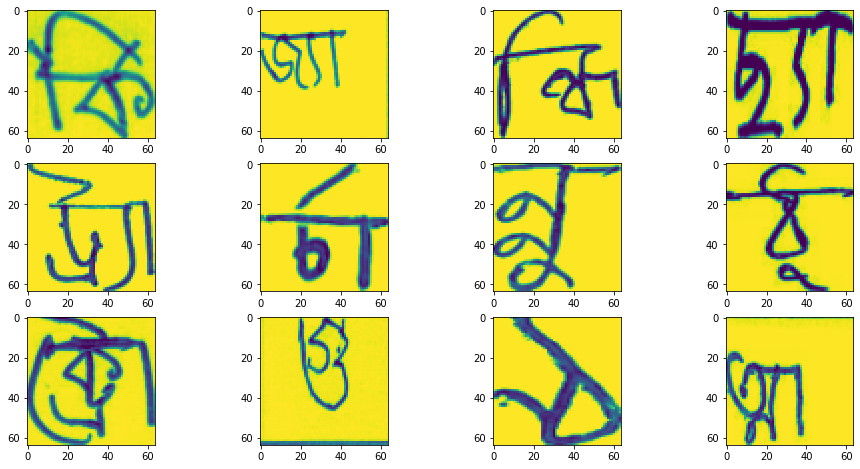

(50210, 32332)


In [0]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'/content/gdrive/My Drive/bengalchar/bengalichar/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(IMG_SIZE, IMG_SIZE))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic','grapheme'], axis=1)
    print(X_train.shape)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [41]:
train_df.shape[0]

50210

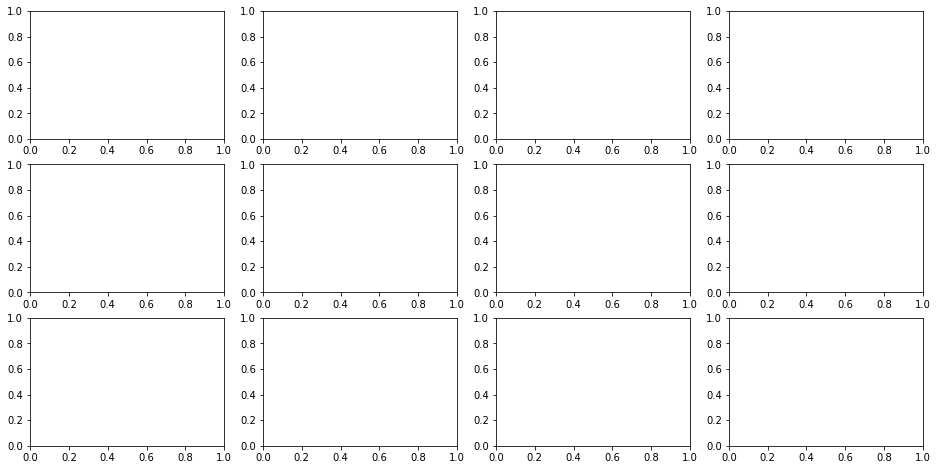

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))

In [37]:
for row in ax:


  print(row)
  for col in row:
    
    print(col)

AxesSubplot(0.125,0.657941;0.168478x0.222059)
AxesSubplot(0.327174,0.657941;0.168478x0.222059)
AxesSubplot(0.529348,0.657941;0.168478x0.222059)
AxesSubplot(0.731522,0.657941;0.168478x0.222059)
AxesSubplot(0.125,0.391471;0.168478x0.222059)
AxesSubplot(0.327174,0.391471;0.168478x0.222059)
AxesSubplot(0.529348,0.391471;0.168478x0.222059)
AxesSubplot(0.731522,0.391471;0.168478x0.222059)
AxesSubplot(0.125,0.125;0.168478x0.222059)
AxesSubplot(0.327174,0.125;0.168478x0.222059)
AxesSubplot(0.529348,0.125;0.168478x0.222059)
AxesSubplot(0.731522,0.125;0.168478x0.222059)


In [38]:
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d27a36390>,
      dtype=object)

In [44]:
train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
##train_df.loc[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331,grapheme
0,246,253,251,250,249,252,246,250,250,247,250,247,245,246,250,250,243,251,250,244,247,251,248,247,250,247,245,248,250,248,249,248,249,248,244,249,248,247,248,247,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,253,র্দ্দ
1,250,245,241,244,249,253,253,254,254,254,254,254,254,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,...,254,254,254,254,253,253,254,254,254,253,254,253,254,255,255,255,255,255,255,255,254,254,255,255,254,254,254,254,255,254,254,253,253,253,254,255,253,253,254,গ্লি
2,248,248,249,249,250,251,250,250,249,250,252,251,250,251,251,247,248,250,246,243,248,249,248,247,246,244,246,247,247,247,246,249,248,240,245,249,248,251,252,251,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,ন্ত্রী
3,253,252,250,252,252,251,252,252,252,251,249,252,251,251,250,247,251,249,249,250,250,249,250,251,249,250,251,250,250,250,251,250,250,251,250,251,252,251,251,252,...,253,253,254,254,254,254,254,254,254,254,255,254,254,254,254,255,255,255,254,253,253,253,253,253,252,252,251,251,252,252,252,253,252,252,251,250,251,251,253,দ্বৈ
4,250,252,252,250,250,252,253,254,254,254,253,253,252,253,253,253,251,250,252,254,254,252,252,251,250,252,253,252,250,249,252,252,252,252,252,250,250,251,252,252,...,248,250,251,252,251,248,245,248,251,252,251,250,250,251,251,251,251,251,251,250,250,250,250,251,252,253,252,250,250,251,252,251,250,251,252,252,252,252,252,পৌঁ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,255,255,255,255,255,255,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,255,253,নৌ
50206,220,220,217,227,229,223,226,224,224,229,215,205,214,219,223,227,220,214,215,211,213,224,217,217,222,214,217,228,223,220,226,216,211,222,220,216,221,217,214,218,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,254,255,255,254,253,251,স্ত্রো
50207,249,248,244,244,244,245,248,251,253,251,250,247,247,249,251,251,251,251,252,252,251,251,252,251,250,251,252,252,251,249,251,252,252,251,251,246,243,247,251,252,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,স্যা
50208,251,253,254,254,254,254,254,253,253,253,253,253,253,253,253,253,253,254,254,254,254,254,254,254,254,254,254,253,253,252,254,254,254,254,254,254,254,254,254,255,...,254,254,254,254,254,254,254,254,255,255,255,255,255,255,255,254,254,254,254,253,253,252,252,252,254,254,254,254,254,254,254,254,253,253,253,254,254,255,254,শ্নো
